<a href="https://www.kaggle.com/code/mohdmuttalib/walmart-sales-forecasting?scriptVersionId=135162043" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Contact Information

- **Name** - Mohd Muttalib
- **Phone** - +91-8445818187
- **Email** - muttalib1326@gmail.com
- **Portfolio** - https://github.com/MMuttalib1326

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler


from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv')
stores = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')
features = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv')

In [3]:
data.shape

(421570, 5)

In [4]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [6]:
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [7]:
stores.shape

(45, 3)

In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [10]:
features.shape

(8190, 12)

In [11]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [13]:
features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [14]:
# filling missing values
features['CPI'].fillna(features['CPI'].median(),inplace=True)
features['Unemployment'].fillna(features['Unemployment'].median(),inplace=True)

In [15]:
features['MarkDown1'].value_counts().unique()

array([2, 1])

In [16]:
from pandas.core.ops import flex_arith_method_FRAME
for i in range(1,6):
  features["MarkDown"+str(i)] = features["MarkDown"+str(i)].apply(lambda x: 0 if x<0 else x )
  features["MarkDown"+str(i)].fillna(value=0,inplace=True)

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     8190 non-null   float64
 5   MarkDown2     8190 non-null   float64
 6   MarkDown3     8190 non-null   float64
 7   MarkDown4     8190 non-null   float64
 8   MarkDown5     8190 non-null   float64
 9   CPI           8190 non-null   float64
 10  Unemployment  8190 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [18]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


In [19]:
data = pd.merge(data,stores,on='Store',how='left')

In [20]:
data = pd.merge(data,features,on=['Store','Date'],how='left')
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     421570 non-null  float64
 10  MarkDown2     421570 non-null  float64
 11  MarkDown3     421570 non-null  float64
 12  MarkDown4     421570 non-null  float64
 13  MarkDown5     421570 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [22]:
data['Date'] = pd.to_datetime(data['Date'],errors='coerce')
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Date,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,False,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


In [23]:
#check whether the column IsHoliday_x and IsHoliday_y are same or not
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()

True

In [24]:
#Since this two columns are same so drop any one column and make another column as IsHoliday
data.drop(columns='IsHoliday_x',inplace=True)
data.rename(columns={"IsHoliday_y" : "IsHoliday"}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   Type          421570 non-null  object        
 5   Size          421570 non-null  int64         
 6   Temperature   421570 non-null  float64       
 7   Fuel_Price    421570 non-null  float64       
 8   MarkDown1     421570 non-null  float64       
 9   MarkDown2     421570 non-null  float64       
 10  MarkDown3     421570 non-null  float64       
 11  MarkDown4     421570 non-null  float64       
 12  MarkDown5     421570 non-null  float64       
 13  CPI           421570 non-null  float64       
 14  Unemployment  421570 non-null  float64       
 15  I

In [25]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False


In [26]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.week

/tmp/ipykernel_20/235201722.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['Date'].dt.week


In [27]:
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week
Date,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2010,2,5
2010-02-05,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,6,2010-02-05,3200.22,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,7,2010-02-05,10820.05,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5
2010-02-05,29,8,2010-02-05,20055.64,B,93638,24.36,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,10.064,False,2010,2,5


In [28]:
#Outlier Detection and Abnormalities
agg_data = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
agg_data.head()


,Store,Dept,max,min,mean,median,std
0,1,1,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,1,2,65615.36,35819.83,46102.090420,45561.85,3440.673222
2,1,3,51159.17,6165.73,13150.478042,10366.85,8708.978853
3,1,4,47893.23,32497.43,36964.154476,36579.96,2930.698313
4,1,5,85676.09,11570.27,24257.941119,21183.42,11330.286495


In [29]:
agg_data.isnull().sum()

Store      0
Dept       0
max        0
min        0
mean       0
median     0
std       37
dtype: int64

In [30]:
store_data = pd.merge(left=data,right=agg_data,on=['Store', 'Dept'],how ='left')
store_data.head(2)

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
0,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
1,29,5,2010-02-05,15552.08,B,93638,24.36,2.788,0.0,0.0,...,10.064,False,2010,2,5,69467.35,6642.10,12931.821259,10898.36,8868.631880


In [31]:
store_data.dropna(inplace=True)

In [32]:
data = store_data.copy()

In [33]:
data['Date'] = pd.to_datetime(data['Date'],errors='coerce')
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,0.0,0.0,...,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,0.0,0.0,...,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,0.0,0.0,...,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095


In [34]:
data['Total_MarkDown'] = data['MarkDown1']+data['MarkDown2']+data['MarkDown3']+data['MarkDown4']+data['MarkDown5']
data.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis = 1,inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,False,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032,0.0
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,False,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675,0.0
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,False,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056,0.0
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,False,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236,0.0
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,False,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095,0.0


In [35]:
data.shape

(421533, 20)

In [36]:
numeric_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown']
data_numeric = data[numeric_col].copy()

In [37]:
data_numeric.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,Total_MarkDown
Date,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0.0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0.0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0.0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0.0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0.0


In [38]:
data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis = 1)]
data.shape

(375438, 20)

In [39]:
data=data[data['Weekly_Sales']>=0]
data.shape

(374247, 20)

In [40]:
data['IsHoliday'] = data['IsHoliday'].astype('int')
data.head()

,Store,Dept,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,max,min,mean,median,std,Total_MarkDown
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,2010-02-05,24924.50,A,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,57592.12,14537.37,22513.322937,18535.48,9854.349032,0.0
2010-02-05,9,97,2010-02-05,668.48,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,766.93,-9.92,372.655556,371.05,290.954675,0.0
2010-02-05,9,85,2010-02-05,693.87,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,2512.14,110.56,876.629441,824.04,307.436056,0.0
2010-02-05,8,80,2010-02-05,8654.60,A,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,11990.43,7414.43,9188.915105,9161.97,756.223236,0.0
2010-02-05,9,55,2010-02-05,11123.56,B,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,29166.26,4791.74,8607.050490,7571.60,3874.176095,0.0


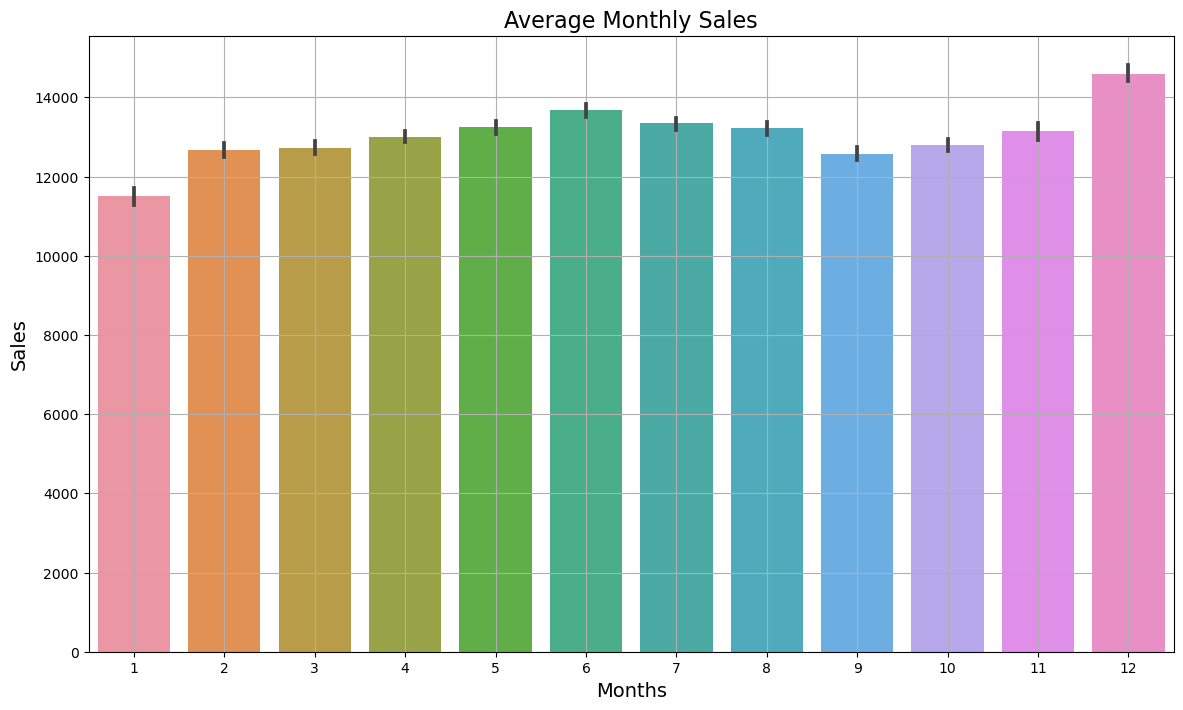

In [41]:
#Average Monthly Sales
plt.figure(figsize=(14,8))
sns.barplot(x='Month',y='Weekly_Sales',data=data)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Average Monthly Sales',fontsize=16)
plt.savefig('avg_monthly_sales.png')
plt.grid()

In [42]:
# Monthly Sales for Each Year
data_monthly = pd.crosstab(data["Year"], data["Month"], values=data["Weekly_Sales"],aggfunc='sum')
data_monthly

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2010,NaN,1.365986e+08,1.369976e+08,1.753251e+08,1.422677e+08,1.455770e+08,1.776954e+08,1.426176e+08,1.344151e+08,1.687452e+08,1.440445e+08,1.927286e+08
2011,1.170809e+08,1.320987e+08,1.341586e+08,1.710181e+08,1.382097e+08,1.441182e+08,1.762046e+08,1.398143e+08,1.668033e+08,1.375280e+08,1.034907e+08,1.597524e+08
2012,1.172222e+08,8.915290e+07,1.734250e+08,1.479222e+08,1.512280e+08,1.902330e+08,1.458221e+08,1.636039e+08,1.432228e+08,1.480537e+08,NaN,NaN


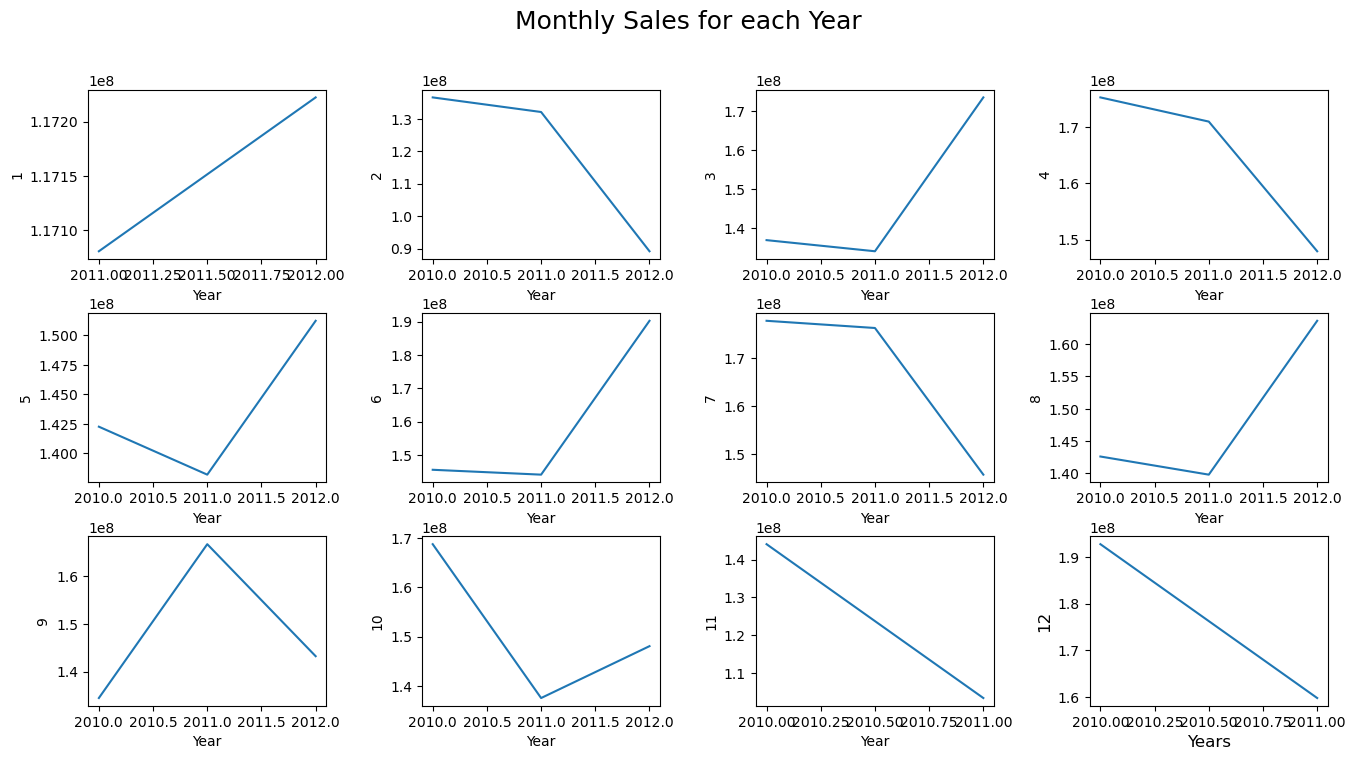

In [43]:
fig, axes = plt.subplots(3,4,figsize=(16,8))
plt.suptitle('Monthly Sales for each Year', fontsize=18)
k=1
for i in range(3):
    for j in range(4):
      sns.lineplot(ax=axes[i,j],data=data_monthly[k])
      plt.subplots_adjust(wspace=0.4,hspace=0.32)
      plt.ylabel(k,fontsize=12)
      plt.xlabel('Years',fontsize=12)
      k+=1

plt.savefig('monthly_sales_every_year.png')
plt.show()

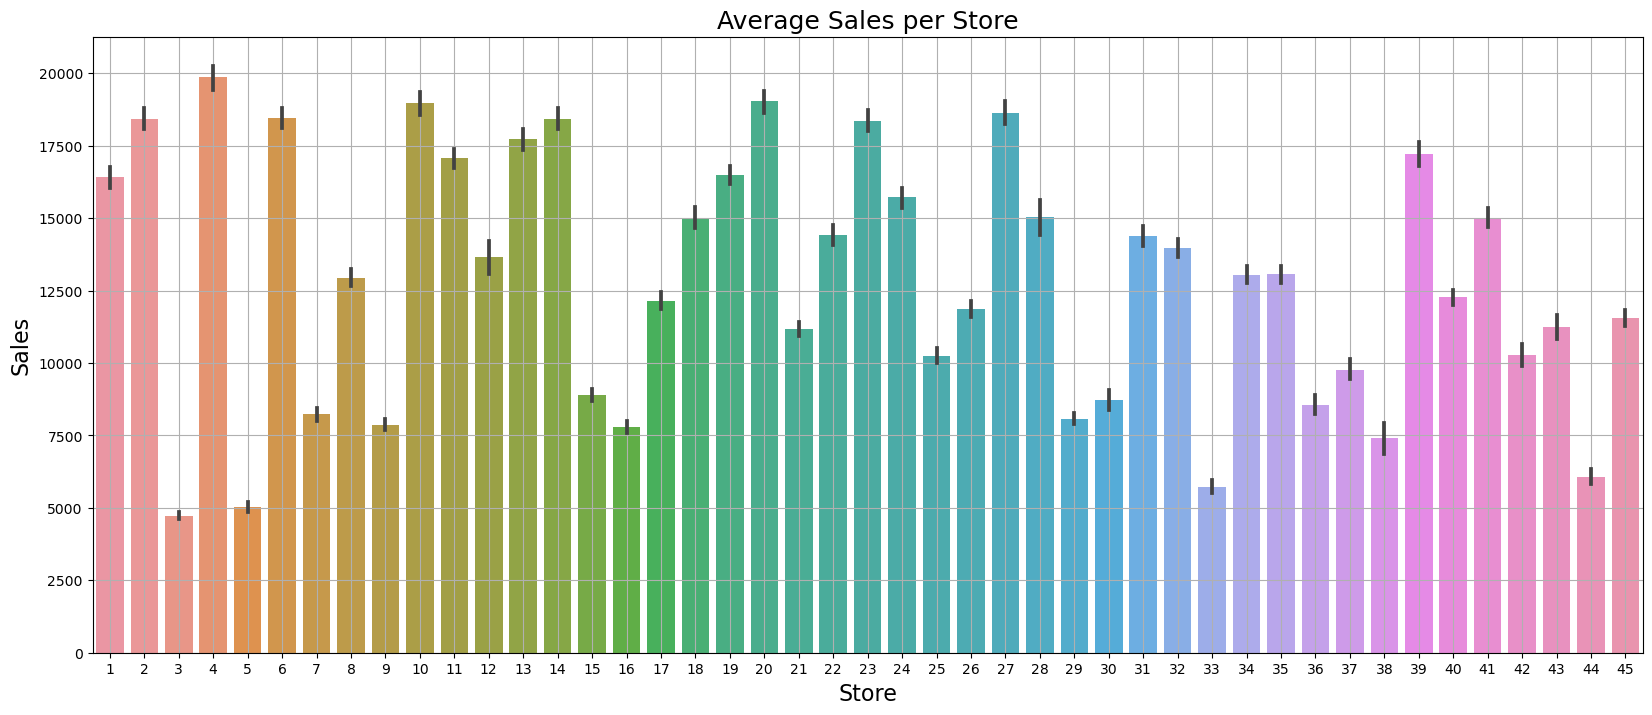

In [44]:
#Average Weekly Sales Store wise
plt.figure(figsize=(20,8))
sns.barplot(x='Store',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.savefig('avg_sales_store.png')
plt.show()

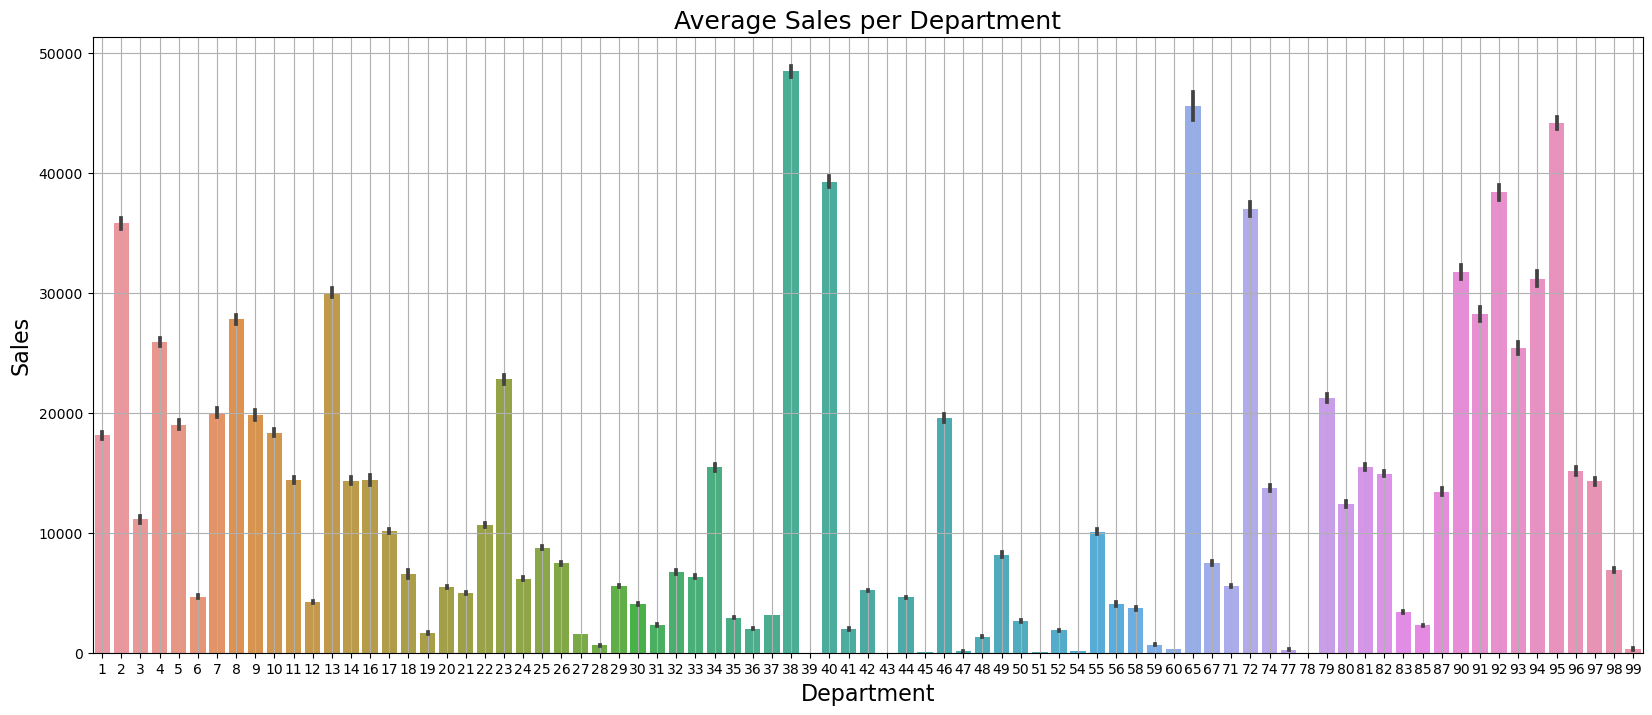

In [45]:
# Average sales per department
plt.figure(figsize=(20,8))
sns.barplot(x='Dept',y='Weekly_Sales',data=data)
plt.grid()
plt.title('Average Sales per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Department', fontsize=16)
plt.savefig('avg_sales_dept.png')
plt.show()

/tmp/ipykernel_20/1590930293.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Temperature'])


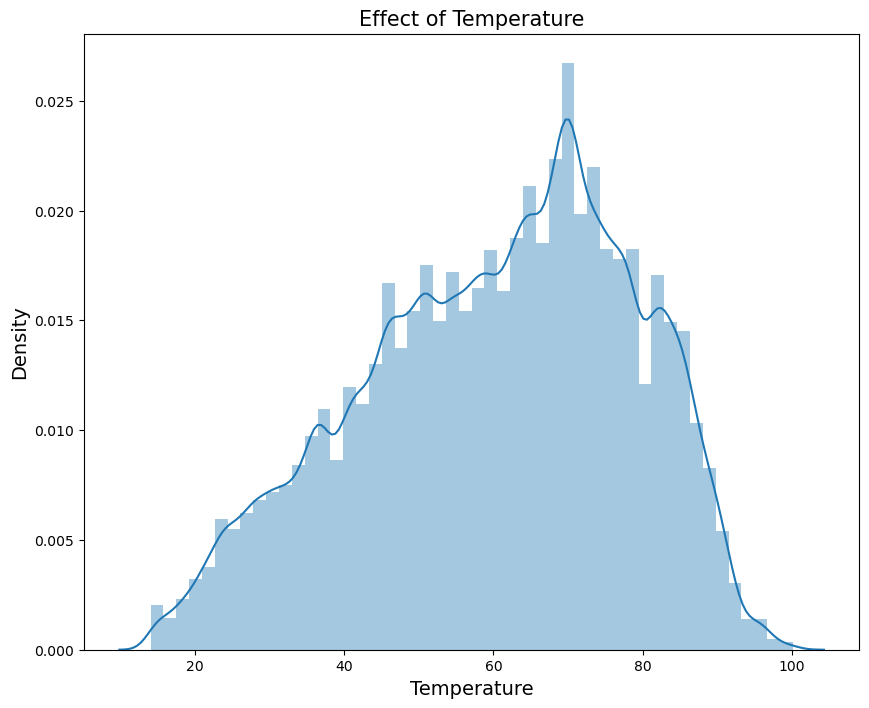

In [46]:
# Effect of Temperature on Sales
plt.figure(figsize=(10,8))
sns.distplot(data['Temperature'])
plt.title('Effect of Temperature',fontsize=15)
plt.xlabel('Temperature',fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.savefig('effect_of_temp.png')
plt.show()

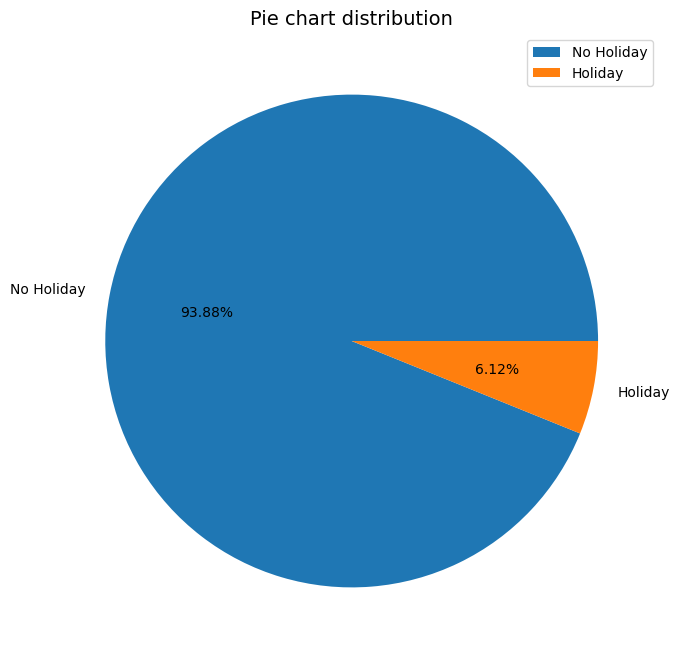

In [47]:
# Holiday Distribution
plt.figure(figsize=(8,8))
plt.pie(data['IsHoliday'].value_counts(),labels=['No Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=14)
plt.legend()
plt.savefig('holiday_distribution.png')
plt.show() 

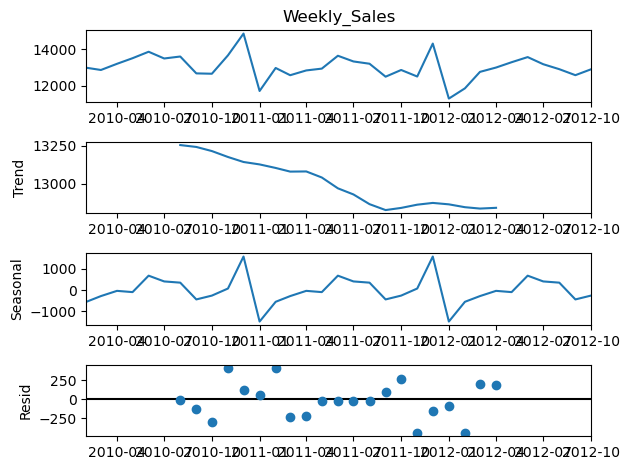

In [48]:
# Time Series Decompose
sm.tsa.seasonal_decompose(data['Weekly_Sales'].resample('MS').mean(), model='additive').plot()
plt.savefig('seasonal_decompose.png')
plt.show()

### One Hot Encoding

In [49]:
data.dtypes

Store                      int64
Dept                       int64
Date              datetime64[ns]
Weekly_Sales             float64
Type                      object
Size                       int64
Temperature              float64
Fuel_Price               float64
CPI                      float64
Unemployment             float64
IsHoliday                  int64
Year                       int64
Month                      int64
Week                       int64
max                      float64
min                      float64
mean                     float64
median                   float64
std                      float64
Total_MarkDown           float64
dtype: object

Here, Store,Dept and Type columns are categorical columns.

In [50]:
cat_col = ['Store','Dept','Type']
data_cat = data[cat_col].copy()
data_cat.head()

,Store,Dept,Type
Date,,,
2010-02-05,1,1,A
2010-02-05,9,97,B
2010-02-05,9,85,B
2010-02-05,8,80,A
2010-02-05,9,55,B


In [51]:
data_cat = pd.get_dummies(data_cat,columns=cat_col)
data_cat.head()

,Store_1,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [52]:
data.shape

(374247, 20)

In [53]:
data = pd.concat([data, data_cat],axis=1)

In [54]:
data.shape

(374247, 149)

In [55]:
data.drop(columns=cat_col,inplace=True)

In [56]:
data.drop(columns=['Date'],inplace=True)

In [57]:
data.shape

(374247, 145)

In [58]:
num_col = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total_MarkDown','max','min','mean','median','std']

In [59]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
  return df

In [60]:
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,668.48,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,693.87,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,8654.60,155078,34.14,2.572,214.471451,6.299,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,11123.56,125833,38.01,2.572,214.655459,6.415,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


In [61]:
data = normalization(data.copy(),num_col)
data.head()

,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Year,Month,Week,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.342576,0.630267,0.328495,0.0501,0.840500,0.508787,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.009188,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,1,0,0,0,1,0
2010-02-05,0.009537,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0
2010-02-05,0.118953,0.650636,0.233627,0.0501,0.873861,0.291286,0,2010,2,5,...,0,0,0,0,0,0,0,1,0,0
2010-02-05,0.152888,0.492338,0.278565,0.0501,0.875680,0.305248,0,2010,2,5,...,0,0,0,0,0,0,0,0,1,0


**Finding Correlation between features**

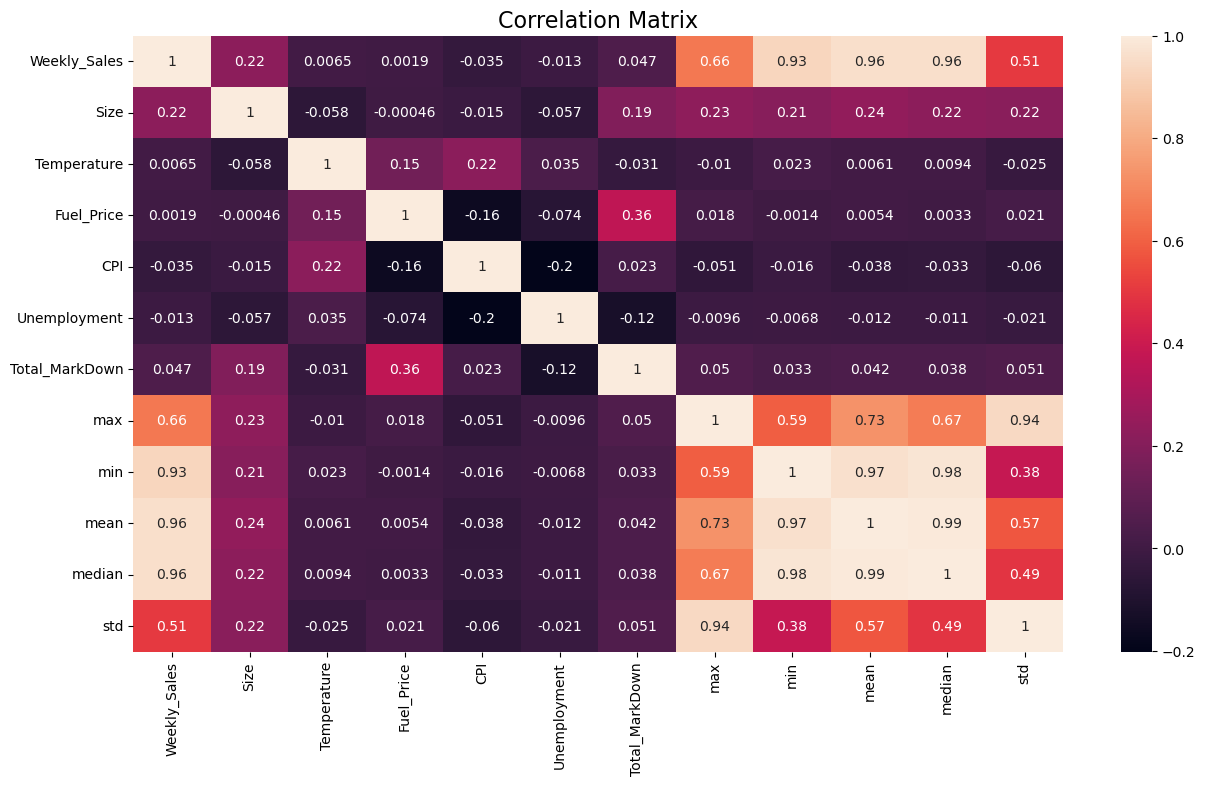

In [62]:
plt.figure(figsize=(15,8))
corr = data[num_col].corr()
sns.heatmap(corr,vmax=1.0,annot=True)
plt.title('Correlation Matrix',fontsize=16)
plt.savefig('correlation_matrix.png')
plt.show()

### Feature Elimination

In [63]:
feature_col = data.columns.difference(['Weekly_Sales'])
feature_col

Index(['CPI', 'Dept_1', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14',
       'Dept_16', 'Dept_17', 'Dept_18',
       ...
       'Type_B', 'Type_C', 'Unemployment', 'Week', 'Year', 'max', 'mean',
       'median', 'min', 'std'],
      dtype='object', length=144)

In [64]:
radm_clf = RandomForestRegressor(oob_score=True,n_estimators=23)
radm_clf.fit(data[feature_col], data['Weekly_Sales'])

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=23, oob_score=True)

In [65]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])

for f in range(data[feature_col].shape[1]):
    feature_rank.loc[f] = [f+1,
                           data[feature_col].columns[indices[f]],
                           radm_clf.feature_importances_[indices[f]]]

feature_rank

,rank,feature,importance
0,1,median,4.961391e-01
1,2,mean,4.318222e-01
2,3,Week,1.962004e-02
3,4,Temperature,9.025345e-03
4,5,max,5.931916e-03
...,...,...,...
139,140,Dept_51,3.142584e-10
140,141,Dept_45,2.206547e-10
141,142,Dept_78,5.851519e-12
142,143,Dept_39,1.952069e-14


In [66]:
x=feature_rank.loc[0:25,['feature']]
x=x['feature'].tolist()
print(x)

['median', 'mean', 'Week', 'Temperature', 'max', 'CPI', 'Fuel_Price', 'min', 'Unemployment', 'std', 'Month', 'Total_MarkDown', 'Dept_16', 'Dept_18', 'IsHoliday', 'Dept_3', 'Size', 'Year', 'Dept_11', 'Dept_1', 'Dept_9', 'Dept_5', 'Dept_7', 'Dept_56', 'Dept_55', 'Dept_72']


In [67]:
X = data[x]
Y = data['Weekly_Sales']

In [68]:
data = pd.concat([X,Y],axis=1)
data.head()

,median,mean,Week,Temperature,max,CPI,Fuel_Price,min,Unemployment,std,...,Year,Dept_11,Dept_1,Dept_9,Dept_5,Dept_7,Dept_56,Dept_55,Dept_72,Weekly_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,0.173215,0.208157,5,0.328495,0.088635,0.840500,0.0501,0.253530,0.508787,0.138276,...,2010,0,1,0,0,0,0,0,0,0.342576
2010-02-05,0.004767,0.004499,5,0.278565,0.001180,0.875680,0.0501,0.064648,0.305248,0.004083,...,2010,0,0,0,0,0,0,0,0,0.009188
2010-02-05,0.008968,0.009135,5,0.278565,0.003866,0.875680,0.0501,0.066212,0.305248,0.004314,...,2010,0,0,0,0,0,0,0,0,0.009537
2010-02-05,0.086290,0.085594,5,0.233627,0.018453,0.873861,0.0501,0.161046,0.291286,0.010611,...,2010,0,0,0,0,0,0,0,0,0.118953
2010-02-05,0.071542,0.080242,5,0.278565,0.044887,0.875680,0.0501,0.126993,0.305248,0.054362,...,2010,0,0,0,0,0,0,1,0,0.152888


# Building the models

**Splitting data into train and test data**



In [69]:
X = data.drop(['Weekly_Sales'],axis=1)
Y = data.Weekly_Sales

In [70]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

## 1. Linear Regression Model

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [72]:
linear_regression_accuracy = lr.score(X_test,y_test)*100
print("Linear Regressor Accuracy - ",linear_regression_accuracy)

Linear Regressor Accuracy -  92.28379328908018


In [73]:
y_pred = lr.predict(X_test)

In [74]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.030079215293536132
MSE 0.0034837903884710336
RMSE 0.059023642622859473
R2 0.9228379352983277


In [75]:
lr_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
lr_df.head()

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.132118
2010-07-09,0.364278,0.280514
2011-07-01,0.005003,0.025738
2012-01-06,0.015856,0.015174
2011-08-26,0.000318,0.001827


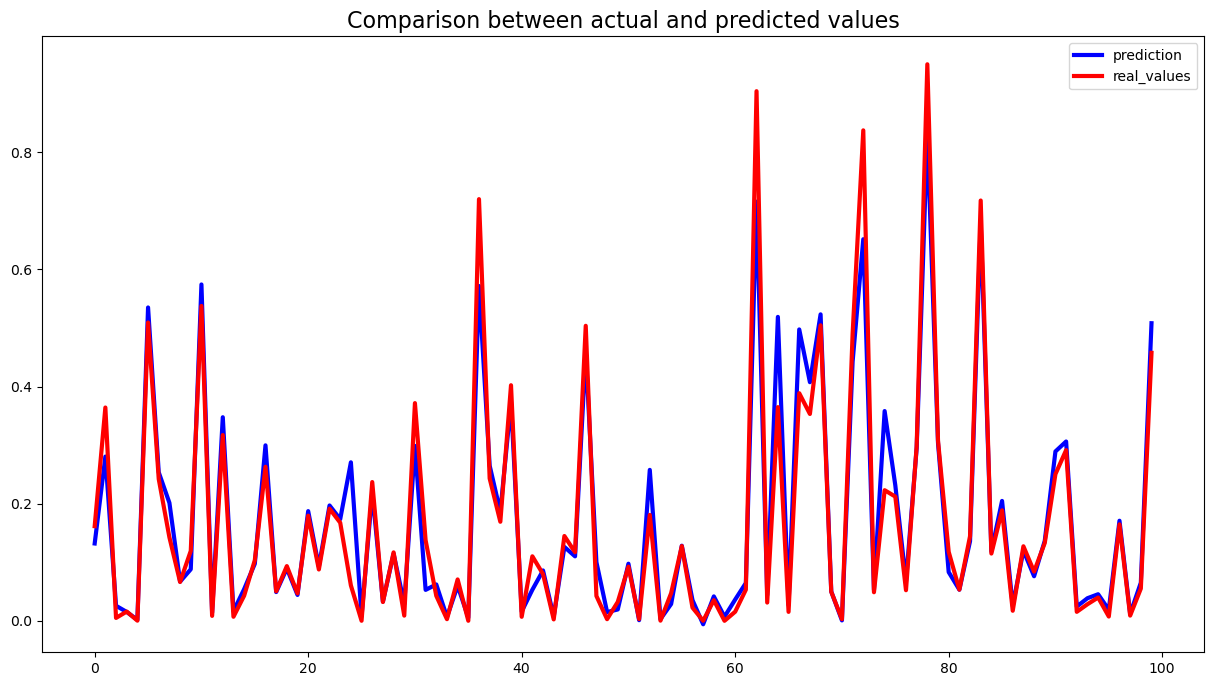

In [76]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(lr.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
#plt.savefig('lr_real_pred.png')
plt.show()

# 2. Random Forest Regressor

In [77]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
random_forest_accuracy = rf.score(X_test,y_test)*100
print("Random Forest Regressor Accuracy - ",random_forest_accuracy)

Random Forest Regressor Accuracy -  97.89874251443092


In [79]:
y_pred = rf.predict(X_test)

In [80]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.015505018124193633
MSE 0.0009486968022213273
RMSE 0.030800922100179522
R2 0.9789879407825056


In [81]:
rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
rf_df.head()

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.127206
2010-07-09,0.364278,0.319979
2011-07-01,0.005003,0.013388
2012-01-06,0.015856,0.020930
2011-08-26,0.000318,0.000490


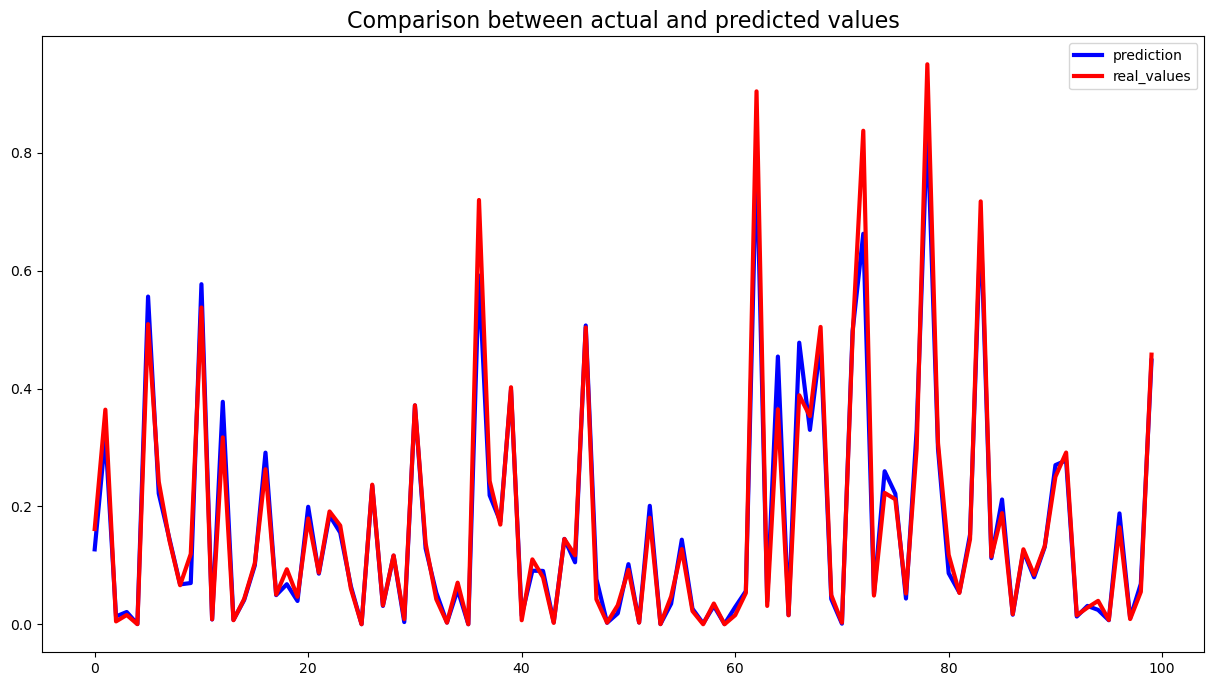

In [82]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(rf.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
# plt.savefig('rf_real_pred.png')
plt.show()

# 3. KNN

In [83]:
knn = KNeighborsRegressor(n_neighbors = 1,weights = 'uniform')
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=1)

In [84]:
knn_accuracy = knn.score(X_test, y_test)*100
print("KNeigbhbors Regressor Accuracy - ",knn_accuracy)

KNeigbhbors Regressor Accuracy -  92.1435515526126


In [85]:
y_pred = knn.predict(X_test)

In [86]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.033150338631610654
MSE 0.003547108134077407
RMSE 0.059557603495082025
R2 0.9215859611622021


In [87]:
knn_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
knn_df.head()

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.112559
2010-07-09,0.364278,0.221307
2011-07-01,0.005003,0.011921
2012-01-06,0.015856,0.028551
2011-08-26,0.000318,0.001063


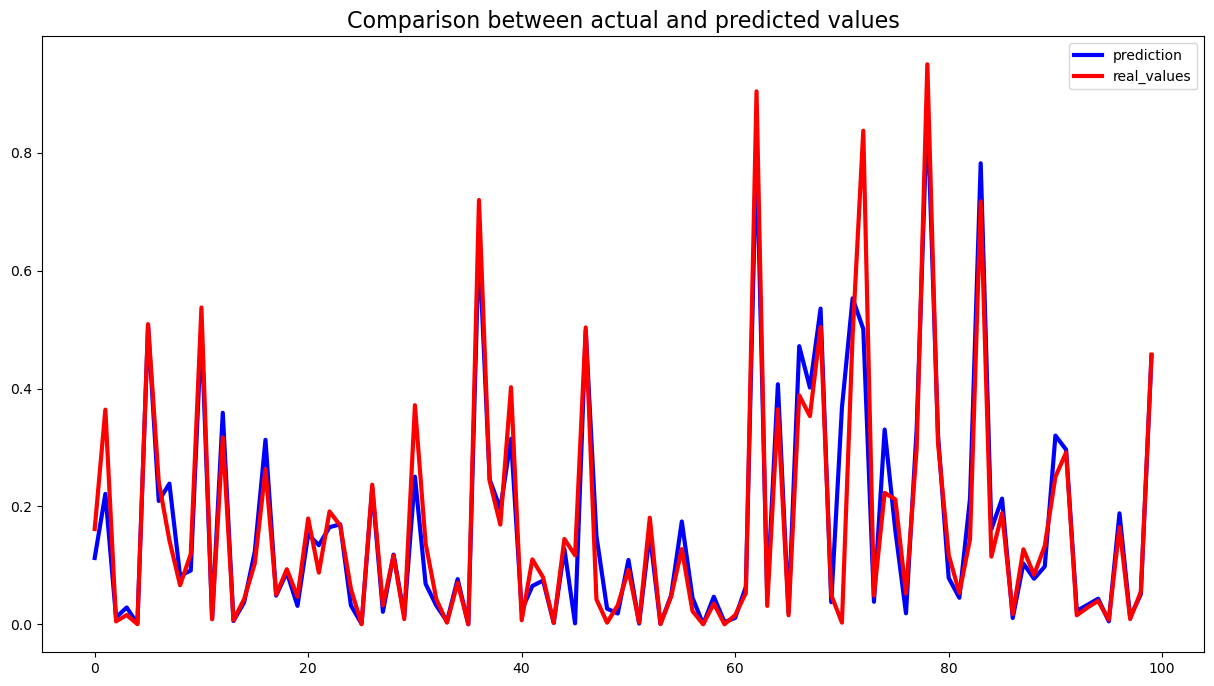

In [88]:
plt.figure(figsize=(15,8))
plt.title('Comparison between actual and predicted values',fontsize=16)
plt.plot(knn.predict(X_test[:100]), label="prediction", linewidth=3.0,color='blue')
plt.plot(y_test[:100].values, label="real_values", linewidth=3.0,color='red')
plt.legend(loc="best")
#plt.savefig('knn_real_pred.png')
plt.show()

# 4. XGBoost Regressor

In [89]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [90]:
xgboost_accuracy = xgbr.score(X_test,y_test)*100
print("XGBoost Regressor Accuracy - ",xgboost_accuracy)

XGBoost Regressor Accuracy -  97.3463074424579


In [91]:
y_pred = xgbr.predict(X_test)

In [92]:
print("MAE" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE" , metrics.mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2" , metrics.explained_variance_score(y_test, y_pred))

MAE 0.01974456712971368
MSE 0.0011981157286570685
RMSE 0.03461380835240567
R2 0.9734634143804428


In [93]:
xgb_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
xgb_df.head()

,Actual,Predicted
Date,,
2011-08-05,0.161661,0.130563
2010-07-09,0.364278,0.313040
2011-07-01,0.005003,0.019386
2012-01-06,0.015856,0.021007
2011-08-26,0.000318,0.000722


# Comparing accuracy of models

In [94]:
acc = {'model':['linear_regression_accuracy','random_forest_accuracy','knn_accuracy','xgboost_accuracy'],'accuracy':[linear_regression_accuracy,random_forest_accuracy,knn_accuracy,xgboost_accuracy]}

In [95]:
acc_df = pd.DataFrame(acc)
acc_df

,model,accuracy
0,linear_regression_accuracy,92.283793
1,random_forest_accuracy,97.898743
2,knn_accuracy,92.143552
3,xgboost_accuracy,97.346307


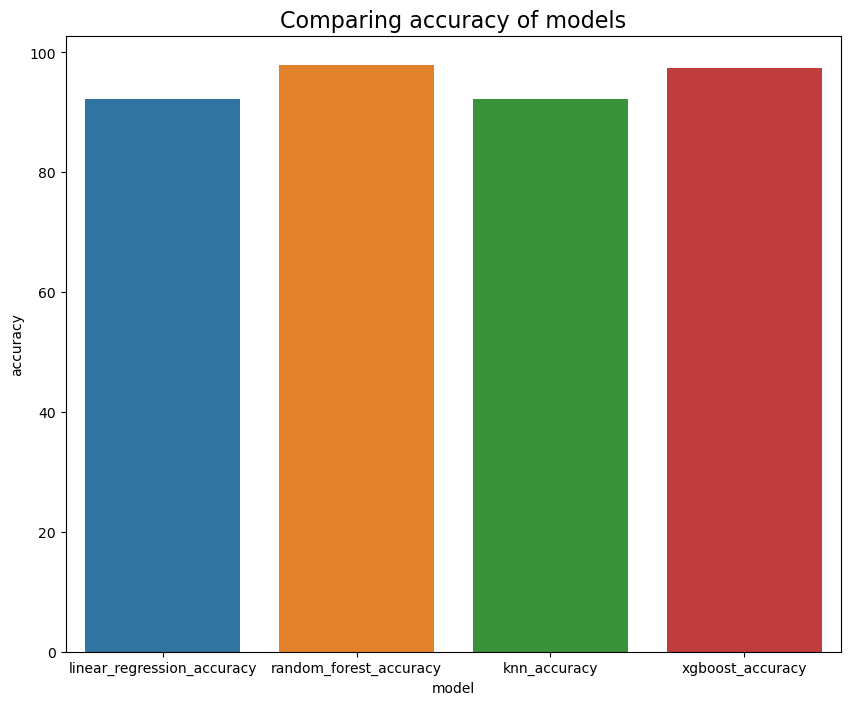

In [96]:
plt.figure(figsize=(10,8))
plt.title('Comparing accuracy of models',fontsize=16)
sns.barplot(x='model',y='accuracy',data=acc_df)
plt.savefig('models_comparison.png')
plt.show()